# 필요한 모듈 import

In [50]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# 데이터셋 불러오기

`stanford_dogs` 데이터셋 사용

In [51]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

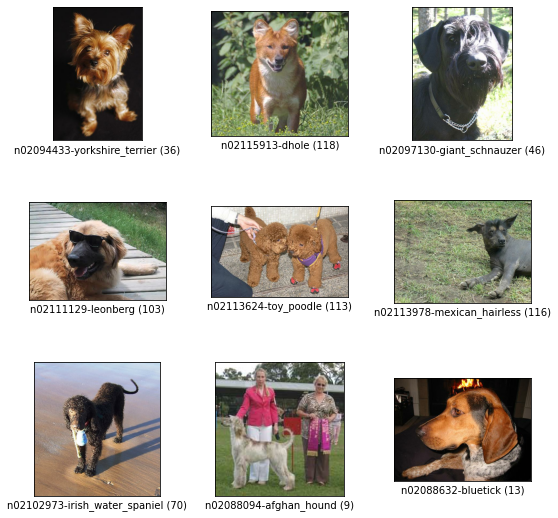

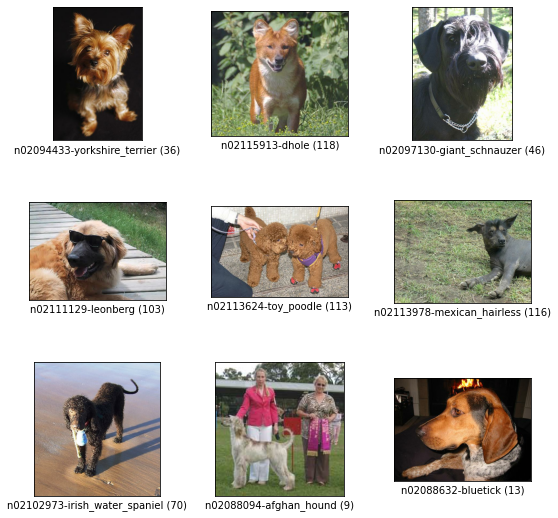

In [52]:
# 데이터 확인
tfds.show_examples(ds_train, ds_info)

# 데이터 전처리

In [53]:
# 데이터 전처리
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [54]:
# augment 적용 함수
def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [55]:
# onehot 함수 구현
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels

# CutMix

In [56]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [57]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [58]:
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [59]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# Mixup

In [60]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [61]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [62]:
# 데이터셋 가공하는 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False, one_hot=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )


    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 모델 만들기

In [63]:
num_classes = ds_info.features["label"].num_classes

In [64]:
# no_augmentation 모델
resnet50 = keras.models.Sequential([
                                    keras.applications.resnet.ResNet50(
                                        include_top=False,
                                        weights='imagenet',
                                        input_shape=(224,224,3),
                                        pooling='avg',
                                    ),
                                    keras.layers.Dense(num_classes, activation='softmax')
])

In [65]:
# augmentation만 적용한 모델
aug_resnet50 = keras.models.Sequential([
                                        keras.applications.resnet.ResNet50(
                                            include_top=False,
                                            weights='imagenet',
                                            input_shape=(224,224,3),
                                            pooling='avg',
                                        ),
                                        keras.layers.Dense(num_classes, activation='softmax')
])

In [66]:
# CutMix 적용 모델
cutmix_resnet50 = keras.models.Sequential([
                                        keras.applications.resnet.ResNet50(
                                            include_top=False,
                                            weights='imagenet',
                                            input_shape=(224,224,3),
                                            pooling='avg',
                                        ),
                                        keras.layers.Dense(num_classes, activation='softmax')
])

In [67]:
# Mixup 적용 모델
mixup_resnet50 = keras.models.Sequential([
                                        keras.applications.resnet.ResNet50(
                                            include_top=False,
                                            weights='imagenet',
                                            input_shape=(224,224,3),
                                            pooling='avg',
                                        ),
                                        keras.layers.Dense(num_classes, activation='softmax')
])

In [68]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [69]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [70]:
EPOCH = 20

In [74]:
# augmentation 적용 안한 데이터 셋

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 99s 124ms/step - loss: 2.2138 - accuracy: 0.4448 - val_loss: 3.6454 - val_accuracy: 0.1669
Epoch 2/20
750/750 [==============================] - 89s 118ms/step - loss: 0.7063 - accuracy: 0.8044 - val_loss: 1.1173 - val_accuracy: 0.6699
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1986 - accuracy: 0.9606 - val_loss: 0.9314 - val_accuracy: 0.7242
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0532 - accuracy: 0.9959 - val_loss: 0.8971 - val_accuracy: 0.7422
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0208 - accuracy: 0.9998 - val_loss: 0.9097 - val_accuracy: 0.7431
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.9217 - val_accuracy: 0.7443
Epoch 7/20
750/750 [==============================] - 93s 125ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.9291 - val_accuracy: 0.7

In [75]:
# augmentation 적용 데이터 셋

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 96s 120ms/step - loss: 2.2961 - accuracy: 0.4253 - val_loss: 2.9275 - val_accuracy: 0.2812
Epoch 2/20
750/750 [==============================] - 89s 118ms/step - loss: 0.9358 - accuracy: 0.7342 - val_loss: 1.1636 - val_accuracy: 0.6509
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.4839 - accuracy: 0.8698 - val_loss: 1.2398 - val_accuracy: 0.6456
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2463 - accuracy: 0.9430 - val_loss: 1.0513 - val_accuracy: 0.6960
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1246 - accuracy: 0.9768 - val_loss: 1.0006 - val_accuracy: 0.7149
Epoch 6/20
750/750 [==============================] - 90s 121ms/step - loss: 0.0717 - accuracy: 0.9895 - val_loss: 1.0007 - val_accuracy: 0.7255
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 0.0413 - accuracy: 0.9949 - val_loss: 0.9699 - val_accuracy: 0.7

In [21]:
# cutmix 사용 데이터셋

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
750/750 [==============================] - 103s 125ms/step - loss: 3.8346 - accuracy: 0.2082 - val_loss: 3.8335 - val_accuracy: 0.1512
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 2.9523 - accuracy: 0.4333 - val_loss: 1.3894 - val_accuracy: 0.6091
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 2.6226 - accuracy: 0.5364 - val_loss: 1.3204 - val_accuracy: 0.6341
Epoch 4/20
750/750 [==============================] - 90s 119ms/step - loss: 2.4063 - accuracy: 0.6068 - val_loss: 1.1961 - val_accuracy: 0.6681
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 2.2478 - accuracy: 0.6588 - val_loss: 1.2687 - val_accuracy: 0.6621
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 2.1229 - accuracy: 0.7042 - val_loss: 1.2155 - val_accuracy: 0.6811
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 2.0544 - accuracy: 0.7082 - val_loss: 1.4126 - val_a

In [22]:
# mixup 사용 데이터셋

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 100s 124ms/step - loss: 3.7353 - accuracy: 0.2355 - val_loss: 3.9511 - val_accuracy: 0.1308
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 2.8354 - accuracy: 0.4860 - val_loss: 1.6473 - val_accuracy: 0.5519
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 2.5614 - accuracy: 0.5973 - val_loss: 1.2867 - val_accuracy: 0.6404
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 2.3716 - accuracy: 0.6637 - val_loss: 1.3531 - val_accuracy: 0.6347
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 2.2395 - accuracy: 0.7134 - val_loss: 1.4338 - val_accuracy: 0.6130
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 2.1372 - accuracy: 0.7532 - val_loss: 1.2263 - val_accuracy: 0.6706
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 2.0515 - accuracy: 0.7891 - val_loss: 1.2982 - val_accuracy: 0.

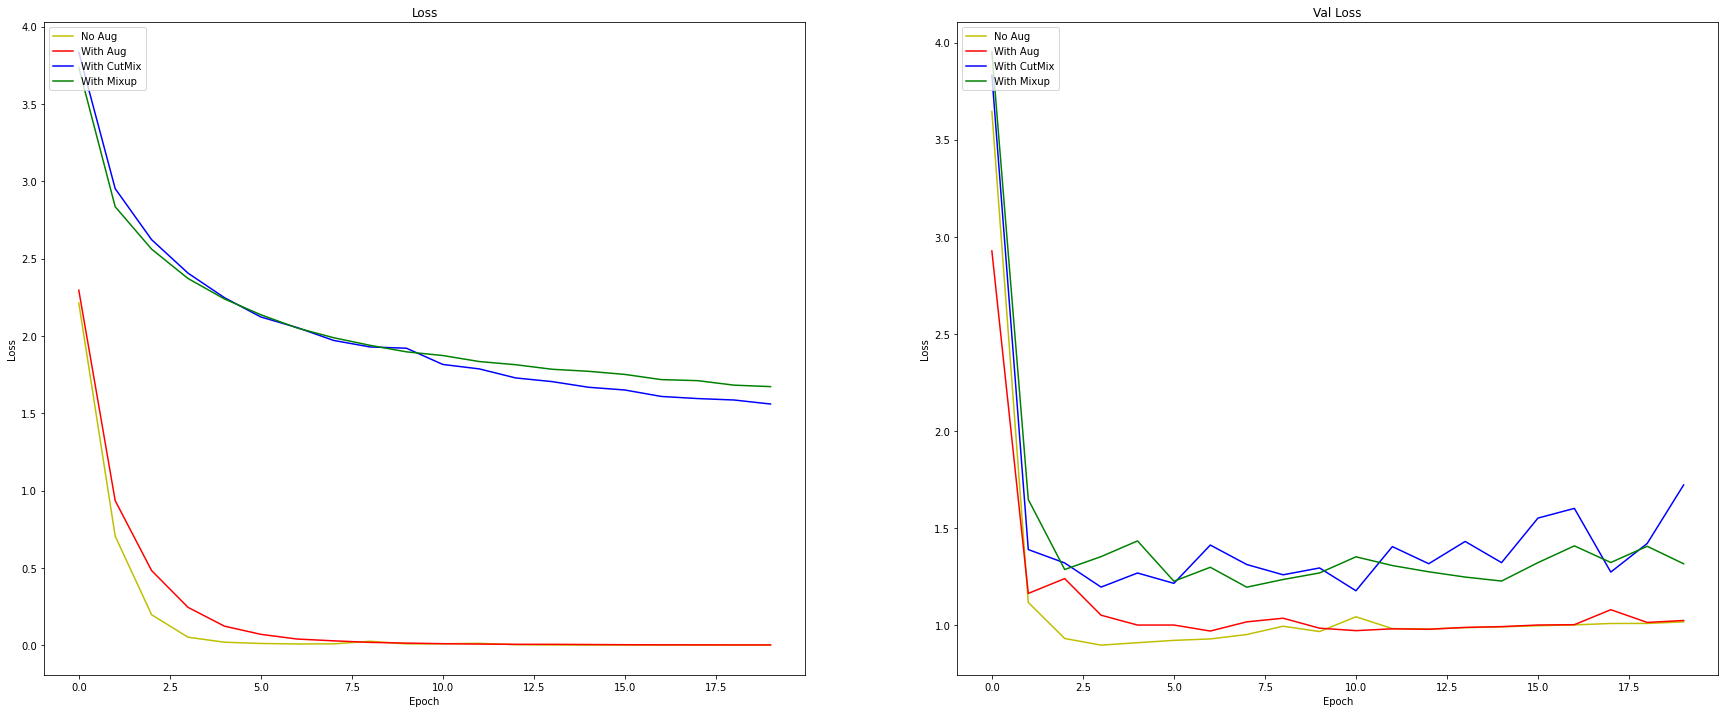

In [77]:
fig = plt.figure(figsize=(30, 12))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['loss'], 'y')
plt.plot(history_resnet50_aug.history['loss'], 'r')
plt.plot(history_resnet50_cutmix.history['loss'], 'b')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'y')
plt.plot(history_resnet50_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'b')
plt.plot(history_resnet50_mixup.history['val_loss'], 'g')
plt.title('Val Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

plt.show()

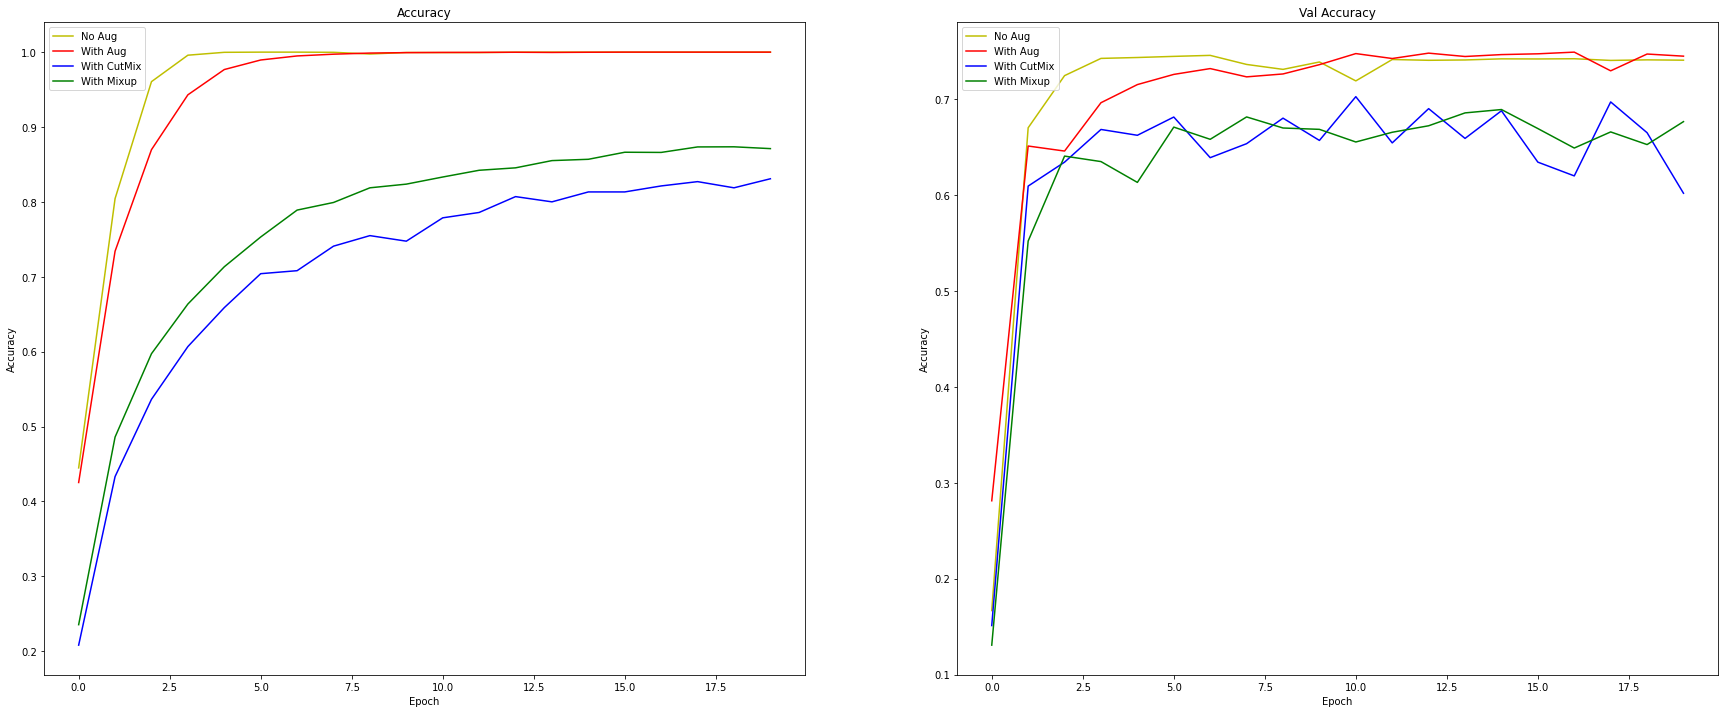

In [80]:
fig = plt.figure(figsize=(30, 12))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'y')
plt.plot(history_resnet50_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['accuracy'], 'g')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.title('Val Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

plt.show()

Going Deeper에 들어가고 난 다음부터는 뭔가 에러도 쉽지 않다   
하지만 결국 코드가 문제고 코드는 정직하다 문제는 나다....


결과를 보면 CutMix, Mixup이 augmentation만 쓴 것보다 더 수준이 떨어진다